100%|██████████| 9.91M/9.91M [00:00<00:00, 12.8MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 340kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 3.21MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 8.01MB/s]


Epoch [1/10], Loss: 164.4406
Epoch [2/10], Loss: 121.4260
Epoch [3/10], Loss: 114.4069
Epoch [4/10], Loss: 111.4229
Epoch [5/10], Loss: 109.7214
Epoch [6/10], Loss: 108.5538
Epoch [7/10], Loss: 107.7527
Epoch [8/10], Loss: 107.0677
Epoch [9/10], Loss: 106.5712
Epoch [10/10], Loss: 106.1309


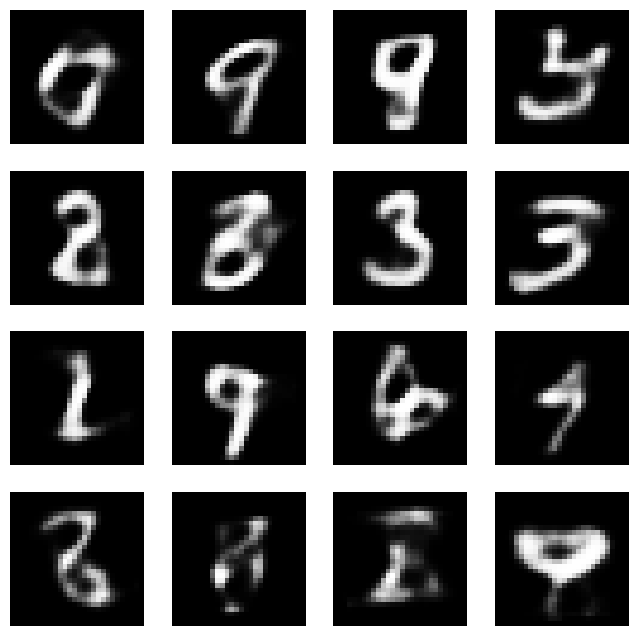

In [ ]:
# VARIATIONAL AUTOENCODER (VAE) IMPLEMENTATION IN PYTORCH
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
import matplotlib.pyplot as plt

# ---- Load MNIST dataset ----
transform = transforms.ToTensor()
train_data = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
train_loader = torch.utils.data.DataLoader(train_data, batch_size=128, shuffle=True)

# ---- Define VAE ----
class VAE(nn.Module):
    def __init__(self):
        super(VAE, self).__init__()
        # Encoder
        self.fc1 = nn.Linear(28*28, 400)
        self.fc_mu = nn.Linear(400, 20)
        self.fc_logvar = nn.Linear(400, 20)
        # Decoder
        self.fc3 = nn.Linear(20, 400)
        self.fc4 = nn.Linear(400, 28*28)

    def encode(self, x):
        h1 = torch.relu(self.fc1(x))
        return self.fc_mu(h1), self.fc_logvar(h1)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        h3 = torch.relu(self.fc3(z))
        return torch.sigmoid(self.fc4(h3))

    def forward(self, x):
        x = x.view(-1, 28*28)
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar

# ---- Loss function ----
def loss_function(recon_x, x, mu, logvar):
    BCE = nn.functional.binary_cross_entropy(recon_x, x.view(-1, 28*28), reduction='sum')
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return BCE + KLD

# ---- Initialize model, optimizer ----
model = VAE()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

# ---- Train ----
epochs = 10
for epoch in range(epochs):
    model.train()
    train_loss = 0
    for data, _ in train_loader:
        optimizer.zero_grad()
        recon_batch, mu, logvar = model(data)
        loss = loss_function(recon_batch, data, mu, logvar)
        loss.backward()
        train_loss += loss.item()
        optimizer.step()
    print(f"Epoch [{epoch+1}/{epochs}], Loss: {train_loss/len(train_loader.dataset):.4f}")

# ---- Generate new samples ----
with torch.no_grad():
    z = torch.randn(16, 20)
    sample = model.decode(z).cpu()
    sample = sample.view(-1, 1, 28, 28)

# Display generated samples
plt.figure(figsize=(8, 8))
for i in range(16):
    plt.subplot(4, 4, i + 1)
    plt.imshow(sample[i].squeeze(), cmap='gray')
    plt.axis('off')
plt.show()
